In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [54]:
data = pd.read_csv('Dataset_Konsumsi_Energi_RumahTangga_Indonesia.csv')
data['Date'] = pd.to_datetime(data['Tahun'].astype(str) + '-' + data['Bulan'].astype(str))
data = data.sort_values(['Provinsi', 'Date'])
data.head()

,Tahun,Bulan,Provinsi,Konsumsi Listrik Rumah Tangga (GWh),Konsumsi Listrik per Kapita (kWh),Date
0,2010,1,Provinsi_1,324.84,1186.17,2010-01-01
34,2010,2,Provinsi_1,318.08,1135.49,2010-02-01
68,2010,3,Provinsi_1,260.84,1167.79,2010-03-01
102,2010,4,Provinsi_1,231.12,1106.22,2010-04-01
136,2010,5,Provinsi_1,358.16,1201.02,2010-05-01


In [52]:
scaler = MinMaxScaler()
data[['Konsumsi Listrik Rumah Tangga (GWh)', 'Konsumsi Listrik per Kapita (kWh)']] = scaler.fit_transform(
    data[['Konsumsi Listrik Rumah Tangga (GWh)', 'Konsumsi Listrik per Kapita (kWh)']])

In [50]:
def create_dataset(data, provinsi, n_steps=12):
    prov_data = data[data['Provinsi'] == provinsi]
    X, y = [], []
    for i in range(len(prov_data) - n_steps):
        X.append(prov_data[['Konsumsi Listrik Rumah Tangga (GWh)', 'Konsumsi Listrik per Kapita (kWh)']].values[i:i+n_steps])
        y.append(prov_data['Konsumsi Listrik Rumah Tangga (GWh)'].values[i+n_steps])
    return np.array(X), np.array(y)

In [48]:
provinsi = 'Provinsi_1'
n_steps = 12
X, y = create_dataset(data, provinsi, n_steps)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = Sequential([
    SimpleRNN(64, activation='relu', input_shape=(n_steps, 2), return_sequences=True),
    Dropout(0.2),
    SimpleRNN(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [44]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [42]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0276 - mae: 0.1305 - val_loss: 0.0195 - val_mae: 0.1139
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0236 - mae: 0.1181 - val_loss: 0.0208 - val_mae: 0.1239
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0284 - mae: 0.1362 - val_loss: 0.0208 - val_mae: 0.1165
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0211 - mae: 0.1116 - val_loss: 0.0222 - val_mae: 0.1289
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0184 - mae: 0.1103 - val_loss: 0.0200 - val_mae: 0.1171
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0240 - mae: 0.1188 - val_loss: 0.0198 - val_mae: 0.1166
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0242 - mae: 0.1206 - val_loss: 0.0198 - val_mae: 0.1182
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0286 - mae: 0.1290 - val_loss: 0.0199 - val_mae: 0.1182
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0235 - mae: 0.1235 - 

In [40]:
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Train Loss: {train_loss[0]}, Test Loss: {test_loss[0]}')

Train Loss: 0.017236759886145592, Test Loss: 0.01907007023692131


In [38]:
y_pred = model.predict(X_test)
y_test_orig = scaler.inverse_transform(np.concatenate([y_test.reshape(-1,1), np.zeros((len(y_test),1))], axis=1))[:,0]
y_pred_orig = scaler.inverse_transform(np.concatenate([y_pred.reshape(-1,1), np.zeros((len(y_pred),1))], axis=1))[:,0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


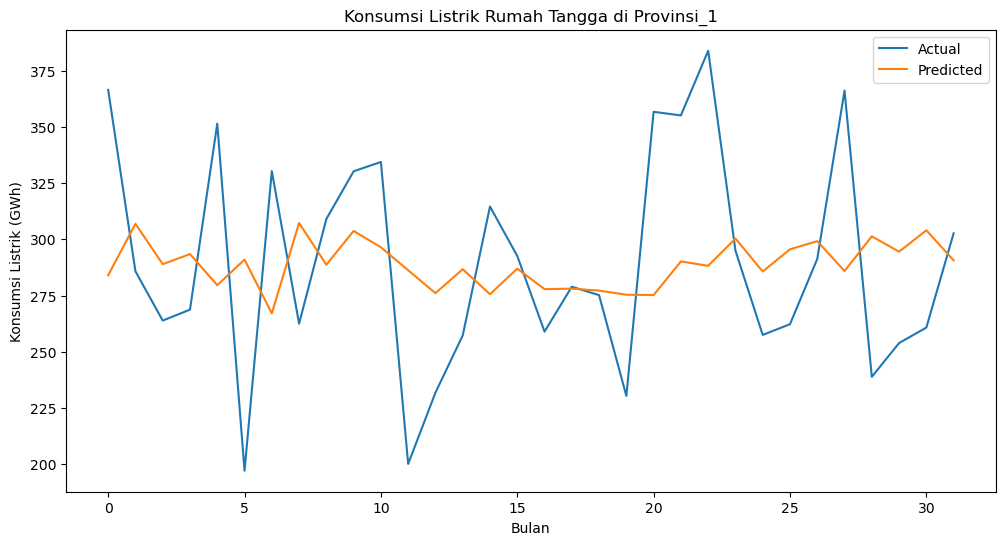

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_orig, label='Actual')
plt.plot(y_pred_orig, label='Predicted')
plt.title(f'Konsumsi Listrik Rumah Tangga di {provinsi}')
plt.xlabel('Bulan')
plt.ylabel('Konsumsi Listrik (GWh)')
plt.legend()
plt.show()

In [34]:
last_sequence = X_test[-1].reshape(1, n_steps, 2)
next_month_pred = model.predict(last_sequence)
next_month_pred_orig = scaler.inverse_transform(np.concatenate([next_month_pred, np.zeros((1,1))], axis=1))[:,0]
print(f'Prediksi konsumsi listrik untuk bulan berikutnya di {provinsi}: {next_month_pred_orig[0]:.2f} GWh')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Prediksi konsumsi listrik untuk bulan berikutnya di Provinsi_1: 290.64 GWh
